In [105]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [106]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [107]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [108]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [109]:
tf.keras.backend.clear_session()

In [110]:
subject = 'Santa Catarina - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [111]:
data = pd.read_csv('2003_mo_model_input_SC.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Santa Catarina - IDH,Santa Catarina - value,Santa Catarina - IDH Renda,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - IDH Longevidade,Santa Catarina - IDH Educacao,Santa Catarina - Consumo de Cimento (t),Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado,Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.797768,0.311113,0.807065,8.256606,1.631497,1018.765911,1169.178062,20.713332,16.132763,75.767229,2.323261,0.852921,0.752747,142.456,20.216800,1.320065e+08,6.638363e+06,19.725168,1.221860e+08,11270.272400,8.001967e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.797853,0.312787,0.806745,8.250731,1.632074,1018.754803,1169.161093,20.714658,16.135412,75.775096,2.323261,0.853282,0.752954,135.829,19.631031,1.321743e+08,6.642080e+06,19.732277,1.222513e+08,11377.902015,8.038182e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.797939,0.314207,0.806425,8.244856,1.632410,1018.748324,1169.151195,20.715432,16.136957,75.779686,2.323261,0.853644,0.753161,133.135,19.400920,1.323421e+08,6.645797e+06,19.739386,1.223166e+08,11480.211275,8.074397e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.798024,0.315571,0.806105,8.238982,1.632446,1018.747630,1169.150134,20.715515,16.137122,75.780177,2.323261,0.854005,0.753368,144.723,19.153741,1.325098e+08,6.649513e+06,19.746495,1.223818e+08,11578.298418,8.110613e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.798110,0.316880,0.805786,8.233107,1.808330,1017.949265,1212.045667,21.273488,16.656851,75.676757,2.319445,0.854366,0.753575,150.523,18.912155,1.326776e+08,6.653230e+06,19.753604,1.224471e+08,11673.320486,8.146828e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42497.575231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42463.822266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42375.031726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42265.885860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


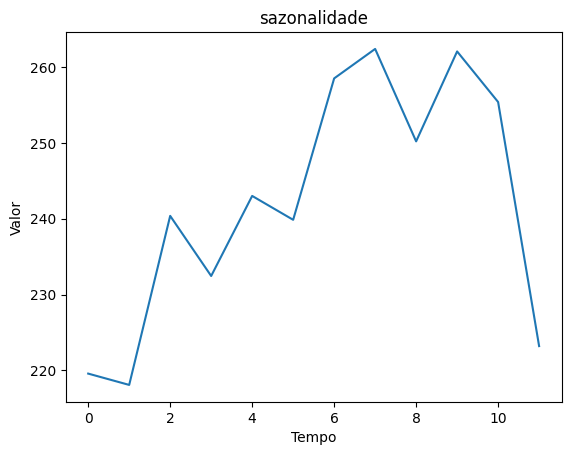

,sazonalidade
sazonalidade,
0,219.591071
1,218.098705
2,240.383349
3,232.458494
4,243.012756
5,239.863999
6,258.505989
7,262.392004
8,250.204324


In [112]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [113]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Santa Catarina - IDH,Santa Catarina - value,Santa Catarina - IDH Renda,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - IDH Longevidade,Santa Catarina - IDH Educacao,Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado,Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Santa Catarina - Consumo de Cimento (t)
0,2003-1,0.797768,0.311113,0.807065,8.256606,1.631497,1018.765911,1169.178062,20.713332,16.132763,75.767229,2.323261,0.852921,0.752747,20.216800,1.320065e+08,6.638363e+06,19.725168,1.221860e+08,11270.272400,8.001967e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,219.591071,142.456
1,2003-2,0.797853,0.312787,0.806745,8.250731,1.632074,1018.754803,1169.161093,20.714658,16.135412,75.775096,2.323261,0.853282,0.752954,19.631031,1.321743e+08,6.642080e+06,19.732277,1.222513e+08,11377.902015,8.038182e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,218.098705,135.829
2,2003-3,0.797939,0.314207,0.806425,8.244856,1.632410,1018.748324,1169.151195,20.715432,16.136957,75.779686,2.323261,0.853644,0.753161,19.400920,1.323421e+08,6.645797e+06,19.739386,1.223166e+08,11480.211275,8.074397e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,240.383349,133.135
3,2003-4,0.798024,0.315571,0.806105,8.238982,1.632446,1018.747630,1169.150134,20.715515,16.137122,75.780177,2.323261,0.854005,0.753368,19.153741,1.325098e+08,6.649513e+06,19.746495,1.223818e+08,11578.298418,8.110613e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,232.458494,144.723
4,2003-5,0.798110,0.316880,0.805786,8.233107,1.808330,1017.949265,1212.045667,21.273488,16.656851,75.676757,2.319445,0.854366,0.753575,18.912155,1.326776e+08,6.653230e+06,19.753604,1.224471e+08,11673.320486,8.146828e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,243.012756,150.523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42497.575231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243.012756,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42463.822266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239.863999,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42375.031726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.505989,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42265.885860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.392004,NaN


In [114]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      134.837
1      136.495
2      154.807
3      146.582
4      149.537
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Santa Catarina - Consumo de Cimento (t), Length: 249, dtype: float64

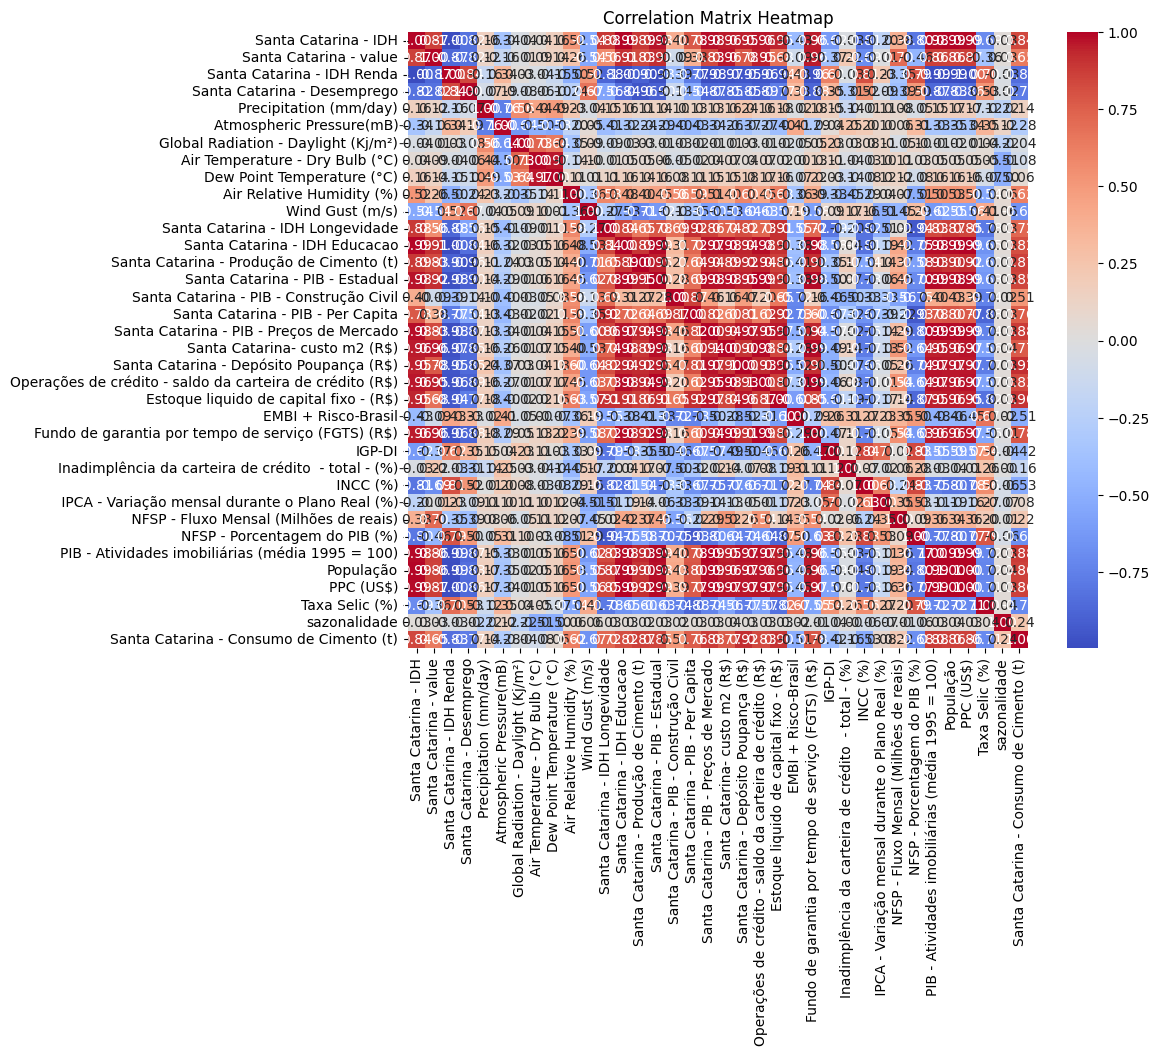

In [115]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [116]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [117]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Santa Catarina - IDH,5.731043e+09
1,Santa Catarina - value,8.724273e+05
2,Santa Catarina - IDH Renda,6.628460e+04
3,Santa Catarina - Desemprego,1.753907e+04
4,Precipitation (mm/day),2.405955e+02
5,Atmospheric Pressure(mB),2.459639e+06
6,Global Radiation - Daylight (Kj/m²),2.243369e+03
7,Air Temperature - Dry Bulb (°C),1.956742e+06
8,Dew Point Temperature (°C),1.311873e+06
9,Air Relative Humidity (%),1.285189e+06


In [118]:
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 5


,Santa Catarina - value,Santa Catarina - IDH Renda,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - IDH Longevidade,Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,0.311113,0.807065,8.256606,1.631497,1018.765911,1169.178062,20.713332,16.132763,75.767229,2.323261,0.852921,20.216800,1.320065e+08,6.638363e+06,11270.272400,8.001967e+06,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,219.591071
1,0.312787,0.806745,8.250731,1.632074,1018.754803,1169.161093,20.714658,16.135412,75.775096,2.323261,0.853282,19.631031,1.321743e+08,6.642080e+06,11377.902015,8.038182e+06,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,218.098705
2,0.314207,0.806425,8.244856,1.632410,1018.748324,1169.151195,20.715432,16.136957,75.779686,2.323261,0.853644,19.400920,1.323421e+08,6.645797e+06,11480.211275,8.074397e+06,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,240.383349
3,0.315571,0.806105,8.238982,1.632446,1018.747630,1169.150134,20.715515,16.137122,75.780177,2.323261,0.854005,19.153741,1.325098e+08,6.649513e+06,11578.298418,8.110613e+06,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,232.458494
4,0.316880,0.805786,8.233107,1.808330,1017.949265,1212.045667,21.273488,16.656851,75.676757,2.319445,0.854366,18.912155,1.326776e+08,6.653230e+06,11673.320486,8.146828e+06,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,243.012756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.528337,0.769786,5.462946,1.873645,1017.436089,1156.795801,20.388783,15.822465,76.227485,2.180702,0.870843,119.903316,1.591779e+08,6.747095e+06,28244.757381,1.885693e+07,3.068648e+06,7.783063e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,416.859692,0.583985,262.392004
176,0.529349,0.769835,5.453853,1.938038,1016.259903,1220.196315,21.150036,16.559850,76.201819,2.243880,0.870583,119.416618,1.591753e+08,6.748100e+06,28380.231371,1.892724e+07,3.070265e+06,7.780841e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,417.748887,0.753312,250.204324
177,0.530555,0.769884,5.444760,2.024270,1014.758677,1273.436844,21.868468,17.135385,75.729293,2.228561,0.870323,119.349729,1.591727e+08,6.749105e+06,28514.850937,1.899755e+07,3.078615e+06,7.778619e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,418.601189,0.882343,262.060571
178,0.531549,0.769932,5.435667,2.136842,1014.095603,1321.529852,22.552000,17.710629,75.286177,2.196865,0.870063,119.499010,1.591701e+08,6.750110e+06,28650.019152,1.906787e+07,3.083099e+06,7.776397e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,419.430070,1.004174,255.391914


In [119]:
input_data = data.iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Santa Catarina - IDH Renda,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - IDH Longevidade,Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,1.986646,1.022276,-0.290326,0.736716,0.025204,-0.226145,-0.384532,-0.737507,0.800406,-2.892161,-1.089782,-1.632756,-2.407230,-1.436610,-1.591084,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040,-1.457186
1,1.957687,1.017717,-0.289015,0.733088,0.025071,-0.225411,-0.383015,-0.733878,0.800406,-2.821355,-1.101735,-1.614317,-2.350669,-1.415601,-1.582194,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580,-1.553806
2,1.928729,1.013158,-0.288251,0.730971,0.024993,-0.224983,-0.382130,-0.731761,0.800406,-2.750549,-1.106430,-1.595879,-2.294107,-1.395630,-1.573304,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368,-0.111024
3,1.899771,1.008599,-0.288169,0.730745,0.024985,-0.224938,-0.382035,-0.731534,0.800406,-2.679743,-1.111474,-1.577440,-2.237546,-1.376484,-1.564414,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384,-0.624105
4,1.870813,1.004040,0.111535,0.469963,0.360534,0.083556,-0.084394,-0.779239,0.793353,-2.608937,-1.116404,-1.559002,-2.180984,-1.357936,-1.555525,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088,0.059213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-1.389648,-1.145825,0.259969,0.302337,-0.071656,-0.405582,-0.562235,-0.525204,0.536942,0.619772,0.944353,1.353666,-0.752538,1.876781,1.073508,1.351069,0.605679,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.421090,-1.472938,1.313890
176,-1.385226,-1.152882,0.406305,-0.081857,0.424293,0.015301,-0.139945,-0.537044,0.653702,0.568799,0.934422,1.353380,-0.737241,1.903226,1.090768,1.352673,0.591420,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.432650,-0.879688,0.524819
177,-1.380805,-1.159939,0.602270,-0.572224,0.840766,0.412509,0.189656,-0.755006,0.625390,0.517826,0.933057,1.353094,-0.721944,1.929503,1.108028,1.360954,0.577161,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.443731,-0.427616,1.292432
178,-1.376383,-1.166996,0.858096,-0.788814,1.216972,0.790422,0.519090,-0.959402,0.566813,0.466853,0.936103,1.352808,-0.706646,1.955888,1.125288,1.365401,0.562902,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.454507,-0.000772,0.860681


In [120]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Santa Catarina - IDH Renda,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - IDH Longevidade,Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,1.986646,1.022276,-0.290326,0.736716,0.025204,-0.226145,-0.384532,-0.737507,0.800406,-2.892161,-1.089782,-1.632756,-2.407230,-1.436610,-1.591084,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040,-1.457186
1,1.957687,1.017717,-0.289015,0.733088,0.025071,-0.225411,-0.383015,-0.733878,0.800406,-2.821355,-1.101735,-1.614317,-2.350669,-1.415601,-1.582194,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580,-1.553806
2,1.928729,1.013158,-0.288251,0.730971,0.024993,-0.224983,-0.382130,-0.731761,0.800406,-2.750549,-1.106430,-1.595879,-2.294107,-1.395630,-1.573304,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368,-0.111024
3,1.899771,1.008599,-0.288169,0.730745,0.024985,-0.224938,-0.382035,-0.731534,0.800406,-2.679743,-1.111474,-1.577440,-2.237546,-1.376484,-1.564414,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384,-0.624105
4,1.870813,1.004040,0.111535,0.469963,0.360534,0.083556,-0.084394,-0.779239,0.793353,-2.608937,-1.116404,-1.559002,-2.180984,-1.357936,-1.555525,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088,0.059213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,-1.421995,-1.008391,-0.170513,0.279368,-0.062368,-1.200831,-1.409655,-0.613161,0.400794,1.176188,0.924705,1.323874,-0.732184,1.567962,0.861991,1.407354,0.759879,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.261902,0.499090,1.313890
164,-1.421716,-1.025999,0.202542,-0.035054,0.360207,-0.653595,-0.922165,-0.846036,0.511116,1.136266,0.920746,1.330233,-0.757671,1.592926,0.880131,1.402136,0.749001,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.276272,0.323875,0.524819
165,-1.421436,-1.043606,0.014525,-0.425777,0.715359,0.078672,-0.174586,-0.853427,0.542855,1.096345,0.915830,1.336592,-0.783158,1.618555,0.898270,1.398719,0.738124,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.290351,0.198030,1.292432
166,-1.421157,-1.061213,0.225611,-0.719069,1.385831,0.812510,0.510880,-1.071889,0.484504,1.056424,0.917899,1.342951,-0.808645,1.643746,0.916409,1.393142,0.727246,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.304501,0.502803,0.860681


In [121]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      134.837
1      136.495
2      154.807
3      146.582
4      149.537
        ...   
163    277.811
164    235.885
165    272.671
166    278.592
167    214.658
Name: Santa Catarina - Consumo de Cimento (t), Length: 168, dtype: float64

In [122]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [123]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 29)

In [124]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Santa Catarina - IDH Renda,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - IDH Longevidade,Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
132,-0.744450,-1.107914,0.172158,-0.726608,1.779734,1.516752,1.594753,0.263513,-1.930422,0.252747,1.296447,1.013389,0.277788,0.730945,1.223361,0.992500,0.965586,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.878252,-0.590376,-1.457186
133,-0.738847,-1.089733,-0.064286,-0.560016,1.193201,1.200866,1.309570,0.383869,-1.996551,0.224129,1.292985,1.025595,0.249595,0.755048,1.199254,1.013803,0.962419,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.887574,-0.476859,-1.553806
134,-0.733243,-1.071553,-0.218080,-0.304687,0.070663,0.567906,0.788023,0.861891,-2.191027,0.195511,1.278904,1.037800,0.221401,0.779291,1.175147,1.036490,0.959252,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.896990,-0.089952,-0.111024
135,-0.727639,-1.053372,-0.368182,0.148745,-0.744076,-0.082617,0.183991,1.062526,-2.216796,0.166893,1.263823,1.050006,0.193208,0.803401,1.151039,1.059637,0.956085,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.906245,-0.814200,-0.624105
136,-0.722035,-1.035191,-0.148550,0.396644,-1.020447,-0.683384,-0.440321,1.050677,-2.249856,0.138275,1.247844,1.062211,0.165014,0.827914,1.126932,1.080606,0.952918,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.915208,-0.917944,0.059213
137,-0.716431,-1.017010,-0.174739,0.508494,-1.351095,-0.941869,-0.649428,1.256695,-2.155537,0.109657,1.230915,1.074416,0.136821,0.855694,1.102825,1.101264,0.949751,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.924126,-0.708692,-0.144648
138,-0.710828,-0.998829,0.109644,0.573265,-0.661695,-0.843585,-0.663792,0.798498,-1.971164,0.081039,1.213294,1.086622,0.108627,0.882082,1.078717,1.123860,0.946584,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.932114,-0.496126,1.062297
139,-0.705224,-0.980648,0.225194,0.255163,-0.049745,-0.501590,-0.436001,0.365659,-1.733997,0.052421,1.194877,1.098827,0.080434,0.908382,1.054610,1.150086,0.943417,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.939863,-0.251065,1.313890
140,-0.699620,-0.962467,0.189834,-0.094293,0.370801,0.064173,0.130000,0.308629,-1.555868,0.023803,1.175612,1.111033,0.052240,0.935470,1.030503,1.179474,0.940250,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.947944,-0.593206,0.524819
141,-0.694016,-0.944286,0.532354,-0.351387,1.275675,0.718711,0.646083,-0.217713,-1.499110,-0.004815,1.155747,1.123238,0.024046,0.963266,1.006395,1.214576,0.937082,-0.384008,1.141593,0.727143,-1.291433,-0.292462,1.797860,1.166380,-0.273241,1.105221,0.956229,-0.100794,1.292432


In [125]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 29)

In [126]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(144, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [127]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [128]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    return df_results, predictions

In [129]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            print(f"\n\Results: {i} ___________________________________________")
            display(df_results.T)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [130]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[2325772156, 1244571012, 856878358, 2298788568, 1758785974, 1452900870, 3236786578, 2972208927, 4274783858, 1448089309]


Step: 0 ___________________________________________
val_loss: 604.4864501953125
winner_seed: 2325772156


Step: 1 ___________________________________________
val_loss: 675.1829223632812


Step: 2 ___________________________________________
val_loss: 539.3631591796875
winner_seed: 856878358


Step: 3 ___________________________________________
val_loss: 531.4544067382812
winner_seed: 2298788568


Step: 4 ___________________________________________
val_loss: 617.1071166992188


Step: 5 ___________________________________________
val_loss: 583.2821655273438


Step: 6 ___________________________________________
val_loss: 601.9042358398438


Step: 7 ___________________________________________
val_loss: 4130.55224609375


Step: 8 ___________________________________________
val_loss: 504.6332702636719
winner_seed: 4274783858


Step: 9 ______________________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,220.794968,228.684418,238.463364,256.16626,258.239899,270.947205,278.936768,285.757202,288.783051,280.266602,259.995361,226.806366
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,31.905029,17.461578,17.409637,17.132751,12.678101,14.342194,24.589233,13.526794,4.233063,27.309387,21.321625,0.573364


[663840735, 2190268501, 580255148, 940255287, 1699228949, 2921155997, 3246398864, 1706674431, 2779990851, 211170785]


Step: 0 ___________________________________________
val_loss: 690.4176635742188
winner_seed: 663840735


Step: 1 ___________________________________________
val_loss: 576.6532592773438
winner_seed: 2190268501


Step: 2 ___________________________________________
val_loss: 496.45611572265625
winner_seed: 580255148


Step: 3 ___________________________________________
val_loss: 588.9553833007812


Step: 4 ___________________________________________
val_loss: 556.5061645507812


Step: 5 ___________________________________________
val_loss: 650.140625


Step: 6 ___________________________________________
val_loss: 583.496826171875


Step: 7 ___________________________________________
val_loss: 433.13677978515625
winner_seed: 1706674431


Step: 8 ___________________________________________
val_loss: 506.727294921875


Step: 9 ___________________________________________
val_

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,228.82869,232.148788,235.996994,246.84761,245.032532,258.085754,269.899109,276.782776,294.840393,295.793518,277.750732,248.788559
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,23.871307,13.997208,19.876007,26.451401,25.885468,1.480743,33.626892,22.501221,10.290405,11.782471,3.566254,22.555557


[2254599968, 1983740621, 2776656629, 3085533245, 2201640060, 2319828180, 2617292936, 1752114893, 3470952980, 1243259919]


Step: 0 ___________________________________________
val_loss: 576.3336181640625
winner_seed: 2254599968


Step: 1 ___________________________________________
val_loss: 600.92333984375


Step: 2 ___________________________________________
val_loss: 559.9306640625
winner_seed: 2776656629


Step: 3 ___________________________________________
val_loss: 744.8506469726562


Step: 4 ___________________________________________
val_loss: 575.3177490234375


Step: 5 ___________________________________________
val_loss: 561.9468383789062


Step: 6 ___________________________________________
val_loss: 601.3877563476562


Step: 7 ___________________________________________
val_loss: 649.7799682617188


Step: 8 ___________________________________________
val_loss: 466.1238708496094
winner_seed: 3470952980


Step: 9 ___________________________________________
val_loss: 595.947326

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,233.967026,232.919434,235.99057,232.031998,235.392136,240.230179,244.673141,250.311096,252.794373,247.38736,237.039612,237.131821
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,18.732971,13.226562,19.882431,41.267014,35.525864,16.374832,58.852859,48.9729,31.755615,60.188629,44.277374,10.898819


[2924138926, 1271326391, 26929886, 1091898882, 3919574174, 3325711011, 629033690, 2381216066, 2216655634, 3822775127]


Step: 0 ___________________________________________
val_loss: 640.1397094726562
winner_seed: 2924138926


Step: 1 ___________________________________________
val_loss: 500.0566101074219
winner_seed: 1271326391


Step: 2 ___________________________________________
val_loss: 439.2939758300781
winner_seed: 26929886


Step: 3 ___________________________________________
val_loss: 654.8713989257812


Step: 4 ___________________________________________
val_loss: 554.60888671875


Step: 5 ___________________________________________
val_loss: 55621812224.0


Step: 6 ___________________________________________
val_loss: 481.06976318359375


Step: 7 ___________________________________________
val_loss: 631.8123779296875


Step: 8 ___________________________________________
val_loss: 582.3314208984375


Step: 9 ___________________________________________
val_loss: 671.72882080078

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,218.427902,234.664536,247.736221,256.779114,269.414337,291.539398,285.553558,301.792419,313.131897,305.653412,279.115723,229.481827
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,34.272095,11.481461,8.13678,16.519897,1.503662,34.934387,17.972443,2.508423,28.581909,1.922577,2.201263,3.248825


[2859378177, 2708661495, 2346395396, 3415752626, 1971795628, 3334906806, 3635997313, 1540857129, 734796374, 2787930510]


Step: 0 ___________________________________________
val_loss: 557.5046997070312
winner_seed: 2859378177


Step: 1 ___________________________________________
val_loss: 643.4573364257812


Step: 2 ___________________________________________
val_loss: 628.6510620117188


Step: 3 ___________________________________________
val_loss: 529.0599365234375
winner_seed: 3415752626


Step: 4 ___________________________________________
val_loss: 594.3626098632812


Step: 5 ___________________________________________
val_loss: 642.7799072265625


Step: 6 ___________________________________________
val_loss: 421.2484436035156
winner_seed: 3635997313


Step: 7 ___________________________________________
val_loss: 528.2440795898438


Step: 8 ___________________________________________
val_loss: 683.2724609375


Step: 9 ___________________________________________
val_loss: 475.37622

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,225.145645,240.151825,238.454071,241.147308,242.596573,244.270203,252.462067,271.248962,282.012299,278.102905,259.371948,224.757294
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,27.554352,5.994171,17.41893,32.151703,28.321426,12.334808,51.063934,28.035034,2.537689,29.473083,21.945038,1.475708


[2121447738, 3445361171, 843520849, 2196207312, 1382819337, 2193395929, 2350485981, 339071673, 1974411110, 2646065814]


Step: 0 ___________________________________________
val_loss: 652.9064331054688
winner_seed: 2121447738


Step: 1 ___________________________________________
val_loss: 530.3722534179688
winner_seed: 3445361171


Step: 2 ___________________________________________
val_loss: 589.7466430664062


Step: 3 ___________________________________________
val_loss: 566.3599243164062


Step: 4 ___________________________________________
val_loss: 629.3997192382812


Step: 5 ___________________________________________
val_loss: 608.1734619140625


Step: 6 ___________________________________________
val_loss: 721.4932250976562


Step: 7 ___________________________________________
val_loss: 719.5696411132812


Step: 8 ___________________________________________
val_loss: 499.1299743652344
winner_seed: 1974411110


Step: 9 ___________________________________________
val_loss: 1193996

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,224.025635,231.047775,232.009216,242.671906,251.216202,270.694305,271.790039,278.282654,281.913483,277.046448,258.35022,231.581253
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,28.674362,15.098221,23.863785,30.627106,19.701797,14.089294,31.735962,21.001343,2.636505,30.529541,22.966766,5.348251


[2381634473, 3471262746, 2740764120, 1906781500, 3632460519, 709246037, 1679735344, 463902916, 2974006380, 54504473]


Step: 0 ___________________________________________
val_loss: 651.1751098632812
winner_seed: 2381634473


Step: 1 ___________________________________________
val_loss: 608.9616088867188
winner_seed: 3471262746


Step: 2 ___________________________________________
val_loss: 555.8016967773438
winner_seed: 2740764120


Step: 3 ___________________________________________
val_loss: 511.1961364746094
winner_seed: 1906781500


Step: 4 ___________________________________________
val_loss: 1197.8912353515625


Step: 5 ___________________________________________
val_loss: 499.88446044921875
winner_seed: 709246037


Step: 6 ___________________________________________
val_loss: 585.5607299804688


Step: 7 ___________________________________________
val_loss: 601.8195190429688


Step: 8 ___________________________________________
val_loss: 695.6710205078125


Step: 9 ______________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,226.101532,214.427887,243.370575,230.064667,249.984436,264.905029,274.129608,272.577759,278.133057,277.005127,258.302002,244.199554
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,26.598465,31.718109,12.502426,43.234344,20.933563,8.300018,29.396393,26.706238,6.416931,30.570862,23.014984,17.966553


[2614087461, 1809574356, 2607919775, 3938540283, 887506017, 1374408568, 3567047679, 1301239036, 3166980328, 429273004]


Step: 0 ___________________________________________
val_loss: 513.7276611328125
winner_seed: 2614087461


Step: 1 ___________________________________________
val_loss: 531.5742797851562


Step: 2 ___________________________________________
val_loss: 567.882568359375


Step: 3 ___________________________________________
val_loss: 545.5302734375


Step: 4 ___________________________________________
val_loss: 625.7487182617188


Step: 5 ___________________________________________
val_loss: 449.65167236328125
winner_seed: 1374408568


Step: 6 ___________________________________________
val_loss: 493.653564453125


Step: 7 ___________________________________________
val_loss: 497.8658752441406


Step: 8 ___________________________________________
val_loss: 570.470458984375


Step: 9 ___________________________________________
val_loss: 580.3665771484375
1/1 [=============

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,231.783264,229.331024,232.341919,234.154358,252.299957,258.320465,279.654968,287.615356,278.406708,280.066467,268.712799,257.509521
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,20.916733,16.814972,23.531082,39.144653,18.618042,1.715454,23.871033,11.66864,6.14328,27.509521,12.604187,31.27652


[466617032, 254040887, 43398547, 3359060975, 3763533190, 1188924960, 481964597, 2292241138, 2187069190, 2700992742]


Step: 0 ___________________________________________
val_loss: 578.26416015625
winner_seed: 466617032


Step: 1 ___________________________________________
val_loss: 577.9420166015625
winner_seed: 254040887


Step: 2 ___________________________________________
val_loss: 509.816162109375
winner_seed: 43398547


Step: 3 ___________________________________________
val_loss: 547.5785522460938


Step: 4 ___________________________________________
val_loss: 584.5693359375


Step: 5 ___________________________________________
val_loss: 572.529541015625


Step: 6 ___________________________________________
val_loss: 514.37060546875


Step: 7 ___________________________________________
val_loss: 553.1201782226562


Step: 8 ___________________________________________
val_loss: 616.6227416992188


Step: 9 ___________________________________________
val_loss: 410.5361633300781
winne

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,224.288544,232.144714,238.446198,246.290146,268.457489,276.905792,283.343994,296.572784,307.789978,308.881836,294.397247,233.444946
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,28.411453,14.001282,17.426804,27.008865,2.46051,20.300781,20.182007,2.711212,23.23999,1.305847,13.080261,7.211945


[3201714495, 3479199999, 113457211, 466207741, 1828781748, 3496084125, 3871714484, 3047998558, 1246977051, 1805742679]


Step: 0 ___________________________________________
val_loss: 480.0260925292969
winner_seed: 3201714495


Step: 1 ___________________________________________
val_loss: 507.18365478515625


Step: 2 ___________________________________________
val_loss: 420.6109924316406
winner_seed: 113457211


Step: 3 ___________________________________________
val_loss: 533.5729370117188


Step: 4 ___________________________________________
val_loss: 640.9092407226562


Step: 5 ___________________________________________
val_loss: 506.3515930175781


Step: 6 ___________________________________________
val_loss: 526.4127807617188


Step: 7 ___________________________________________
val_loss: 668.5515747070312


Step: 8 ___________________________________________
val_loss: 514.5122680664062


Step: 9 ___________________________________________
val_loss: 566.3302001953125
1/1 [========

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,221.289673,226.374969,233.650528,236.880493,244.340195,242.258942,248.115295,267.815521,262.630981,260.160156,233.263763,230.873047
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,31.410324,19.771027,22.222473,36.418518,26.577805,14.346069,55.410706,31.468475,21.919006,47.415833,48.053223,4.640045


'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,225.465286,230.189529,237.645966,242.303375,251.697342,261.815735,268.855865,278.875671,284.04361,281.036377,262.629944,236.457428
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,27.234714,15.956471,18.227034,30.995625,19.220658,5.210735,34.670135,20.408329,0.50639,26.539623,18.687056,10.224428


In [131]:
display(mae)
display(mape)

255.08467

0.06921691015769442